In [132]:
import numpy as np

class MultiClassNetwork:

    def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
        self.units = units
        self.batch_size = batch_size
        self.w1 = None
        self.b1 = None
        self.w2 = None
        self.b2 = None
        self.a1 = None
        self.losses = []
        self.val_losses = []
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2

    def forpass(self, x):
        z1 = np.dot(x, self.w1) + self.b1
        self.a1 = self.sigmoid(z1)
        z2 = np.dot(self.a1, self.w2) + self.b2
        return z2
      
    def backprop(self, x, err):
        m = len(x)
        w2_grad = np.dot(self.a1.T, err) / m
        b2_grad = np.sum(err) / m
        err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
        w1_grad = np.dot(x.T, err_to_hidden) / m
        b1_grad = np.sum(err_to_hidden, axis=0) / m
        return w1_grad, b1_grad, w2_grad, b2_grad
    
    def sigmoid(self, z):
        z = np.clip(z, -100, None)
        a = 1 / (1 + np.exp(-z))
        return a

    def softmax(self, z):
        z = np.clip(z, -100, None)
        exp_z = np.exp(z)
        return exp_z / np.sum(exp_z, axis=1).reshape(-1, 1)

    def init_weights(self, n_features, n_classes):
        self.w1 = np.random.normal(0, 1, (n_features, self.units))
        self.b1 = np.zeros(self.units)
        self.w2 = np.random.normal(0, 1, (self.units, n_classes))
        self.b2 = np.zeros(n_classes)

    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        np.random.seed(42)
        self.init_weights(x.shape[1], y.shape[1])
        for i in range(epochs):
            loss = 0
            print('.', end='')
            for x_batch, y_batch in self.gen_batch(x, y):
                a = self.training(x_batch, y_batch)
                a = np.clip(a, 1e-10, 1-1e-10)
                loss += np.sum(-y_batch*np.log(a))
            self.losses.append((loss + self.reg_loss()) / len(x))
            self.update_val_loss(x_val, y_val)

    def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size
        if length % self.batch_size:
            bins += 1 
        indexes = np.random.permutation(np.arange(len(x)))
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]
    
    def training(self, x, y):
        m = len(x)
        z = self.forpass(x)
        a = self.softmax(z)
        err = -(y - a)
        w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
        w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
        self.w1 -= self.lr * w1_grad
        self.b1 -= self.lr * b1_grad
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad
        return a

    def predict(self, x):
        z = self.forpass(x)
        return np.argmax(z, axis=1)

    def score(self, x, y):
        return np.mean(self.predict(x) == np.argmax(y, axis=1))

    def reg_loss(self):
          return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
                 self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)
        a = self.softmax(z)
        a = np.clip(a, 1e-10, 1-1e-10)
        val_loss = np.sum(-y_val*np.log(a))
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

# Tensorflow

In [108]:
!pip install tensorflow_gpu==2.10

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [109]:
import tensorflow as tf
tf.__version__

'2.10.0'

In [167]:
(x_train_all, y_train_all), (x_test_, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [111]:
print(x_train_all.shape, y_train_all.shape)

(60000, 28, 28) (60000,)


<function matplotlib.pyplot.show(*args, **kw)>

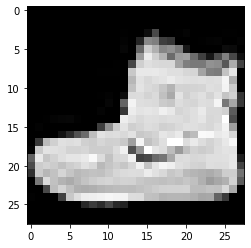

In [112]:
import matplotlib.pyplot as plt
plt.imshow(x_train_all[0], cmap = 'gray')
plt.show

In [113]:
print(y_train_all[:10])

[9 0 0 3 0 2 7 2 5 5]


In [168]:
class_names = ['티셔츠/윗도리', '바지', '스웨터', '드레스', '코트', '샌들', '셔츠', '스니커즈', '가방', '앵클부츠']

In [169]:
print(class_names[y_train_all[0]])

앵클부츠


In [116]:
np.bincount(y_train_all)

array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

In [170]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify = y_train_all, test_size = 0.2, random_state = 42)

In [118]:
np.bincount(y_train)

array([4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800])

In [119]:
np.bincount(y_val)

array([1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200])

In [171]:
x_train = x_train / 255 # 정규화
x_val = x_val / 255

In [172]:
x_train = x_train.reshape(-1, 784)
x_val = x_val.reshape(-1, 784)

In [154]:
print(x_train.shape, x_val.shape)

(48000, 784) (12000, 784)


# One-Hot Encoding

In [123]:
tf.keras.utils.to_categorical([0, 1, 3])

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [173]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

In [125]:
print(y_train_encoded.shape, y_val_encoded.shape)

(48000, 10) (12000, 10)


In [126]:
print(y_train[0], y_train_encoded[0])

6 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [133]:
fc = MultiClassNetwork(units=100, batch_size=256)
fc.fit(x_train, y_train_encoded, x_val=x_val, y_val=y_val_encoded, epochs=40)

........................................

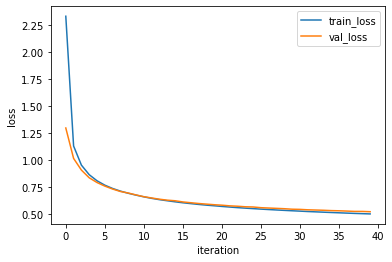

In [134]:
plt.plot(fc.losses)
plt.plot(fc.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [135]:
fc.score(x_val, y_val_encoded)

0.8150833333333334

# 7 - 2 Keras API

* 직점 구현한 다중 분류 신경망은 실전에 사용할 수 있을 정도의 성능을 기대하기 어려움
- 대표적인 딥러닝 패키지인 **Tensorflow**의 **Keras**를 활용

In [ ]:
# 가중치 변수 선언
w = tf.Variable(tf.zeros(shape = (1)))
b = tf.Variable(tf.zeros(shape = (1)))

#경사 하강법 옵티마이저 설정
optimizer = tf.optimizers.SGD(lr = 0.01)

num_epochs = 10
# epoch 횟수만큼 훈련
for setp in range(num_epochs):
  # 자동 미분을 위한 연산 과정 기록
  with tf.GradientTape() as tape:
    z_net = w * x_train + b
    z_net = tf.reshape(z_net, [-1])
    sqr_errors = tf.square(y_train - z_net)
    mean_cost = tf.reduce_mean(sqr_errors)
  # 손실 함수에 대한 가중치 계산
  grads = tape.gradient(mean_cost, [w, b])
  # 옵티마이저에 가중치 반영
  optimizer.apply_gradients(zip(grads, [w, b]))

In [ ]:
model = tf.keras.models.Sequential() # 신경망 모델 만들기
model.add(tf.keras.layers.Dense(1)) # 완전 연결층 추가
model.compile(optimizer = 'sgd', loss = 'mse') # 옵티마이저와 손실 함수를 지정
model.fit(x_train, y_train, epochs = 10) # 훈련 데이터를 사용하여 에포크만큼 훈련

# Keras로 구현하면 확실히 Tensorflow보다 간단해지는 것을 알 수 있음

# Sequential 클래스 사용하기

- **Keras**는 인공신경망 모델을 만들기 위한 **Sequential**클래스와
완전 연결층을 만들기 위한 **Dense**클래스를 제공

  - **Sequential** = '순차적으로 층을 쌓은 신경망 모델'
  - **Dense** = '모델에 포함된 완전 연결층'

- 완전 연결 신경망을 만들기 위해 **Sequential**과 **Dense**를 함께 사용
  - **Sequential**클래스 객체 생성 시 층을 추가 or **add()**를 사용하여 층을 추가

In [159]:
# 객체 생성 시 층을 추가
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
model = Sequential([Dense(...), ...])

In [ ]:
# add()를 사용하여 층을 추가
dense = Dense(...)
model.add(dense)

# Dense클래스의 객체를 만들자마자 전달 가능
model = Sequential()
model.add(Dense(...))
model.add(Dense(...))

# Dense 클래스 사용하기

- 객체를 생성할 때 **unit, activation, kernel_initializer** 매개변수를 전달해야 함
  - unit = 은닉층의 뉴런 개수
  - activation = 활성화 함수 (sigmoid, softmax, tanh, relu, ∙∙∙)
  - kernel_initializer = 가중치 규제 (**Dense**클래스에서는 가중치를 **kernel**이라 함)


In [ ]:
# ex)
Dense(100, activation = 'sigmoid')

# 모델의 최적화 알고리즘과 손실함수 설정

모델을 훈련하기 위해서는 최적화 알고리즘이나 손실함수를 지정해야 함
- 다중 분류
  - 최적화 알고리즘 = 경사하강법
  - 손실함수 = cross-entropy
- **compile()**을 사용하여 지정

In [ ]:
model.compile(optimizer = 'sgd', loss = 'categorical_crossentropy')
# sgd 기본 경사 하강법. lr = 0.01
#############################################
#                   loss                    #
# 제곱오차 - mse                              #
# 로지스틱 - binary_crossentropy              #
# 다중 분류 신경망 - categorical_crossentropy   #
#############################################

# 모델 훈련, 예측, 평가

In [ ]:
model = Sequential()
model.add(Dense(...))
model.add(Dense(...))
model.compile(optimizer = '...', loss = '...')
model.fit(X, y, epochs = ...) # 훈련
model.predict(X) # 예측
model.evaluate(X, y) # 평가

# MNIST 데이터 세트 모델 훈련

In [161]:
# 모델 생성
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
model = Sequential()

In [162]:
# 은닉층과 출력층을 모델에 추가
model.add(Dense(100, activation = 'sigmoid', input_shape = (784,))) # 은닉층의 유닛 개수, 28 * 28크기이므로 (784,)의 튜플 형태
model.add(Dense(10, activation = 'softmax')) # 출력층의 유닛 개수

In [163]:
# 최적화 알고리즘과 손실 함수 지정
model.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy']) # metrics: 훈련 과정 기록으로 정확도를 남기기 위함. 지정하지 않으면 손실값이 기록

In [174]:
# 모델 훈련
history = model.fit(x_train, y_train_encoded, epochs = 40, validation_data = (x_val, y_val_encoded))

Epoch 1/40
1500/1500 [==============================] - 4s 3ms/step - loss: 1.3477 - accuracy: 0.6676 - val_loss: 0.9492 - val_accuracy: 0.7375
Epoch 2/40
1500/1500 [==============================] - 4s 3ms/step - loss: 0.8350 - accuracy: 0.7452 - val_loss: 0.7460 - val_accuracy: 0.7642
Epoch 3/40
1500/1500 [==============================] - 4s 3ms/step - loss: 0.7069 - accuracy: 0.7656 - val_loss: 0.6595 - val_accuracy: 0.7797
Epoch 4/40
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6428 - accuracy: 0.7814 - val_loss: 0.6084 - val_accuracy: 0.7943
Epoch 5/40
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6014 - accuracy: 0.7935 - val_loss: 0.5737 - val_accuracy: 0.8036
Epoch 6/40
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5719 - accuracy: 0.8037 - val_loss: 0.5478 - val_accuracy: 0.8124
Epoch 7/40
1500/1500 [==============================] - 5s 3ms/step - loss: 0.5496 - accuracy: 0.8109 - val_loss: 0.5272 - val_accuracy:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


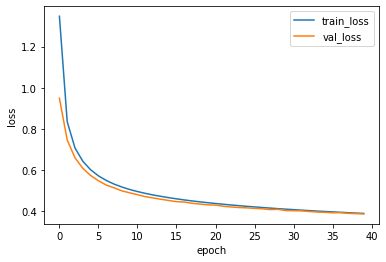

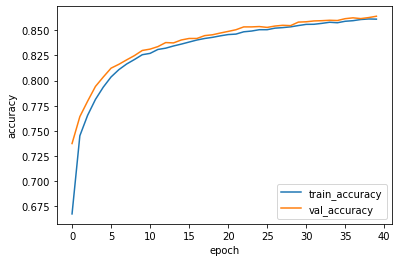

In [175]:
# 손실과 정확도 그래프
print(history.history.keys()) # history의 측정 지표 확인

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()
# 일정한 수준으로 감소하는 추세

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()
# 점진적으로 증가

In [177]:
# 검증 세트 정확도 계산
# evaluate() 사용 시 손실값과 metrics에 추가한 측정 지표를 계산하여 반환
loss, accuracy = model.evaluate(x_val, y_val_encoded, verbose = 0)
print(loss, accuracy)

0.38693690299987793 0.8640000224113464


- 최종 정확도는 86%로 직접 구현한 MultiClassNetwork에 비해 뛰어나게 성능이 좋지는 않다.

- because, 케라스가 이미지 데이터에 잘 맞는 모델이 아니기 때문

- 8장에서 이미지 분류에 아주 효과적인 합성곱 신경망(convolution neural network) 진행